In [1]:
# importing packages and modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import minimize, check_grad
from utils import *
from plotting_utils import *
from analysis_utils import *
import dynamic_glmhmm
from scipy.stats import multivariate_normal, norm

colorsStates = ['tab:orange','tab:blue', 'tab:green','tab:red'] 
sns.set_context("talk")

In [2]:
# setting hyperparameters
S = 20 # sessions
T = 1000 # trials per session
N = T * S # total data points
C = 2 # classes/outputs
K = 2 # states
D = 2 # features/regressors (sensory & bias)

# session start indices
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
sessInd.append(N)

In [3]:
# transformation functions for hypothetical trajectories (only used for plotting)
def generalized_exp(a, b, c, d, x):
    return a * np.exp(b * x + c) + d
def generalized_log(a, b, c, d, x):
    return a * np.log(b * x + c) + d
def generalized_sigmoid(a, b, c, d, x):
    return c * (1 / (1 + np.exp(-a * x + b))) + d

# Figure 1B

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


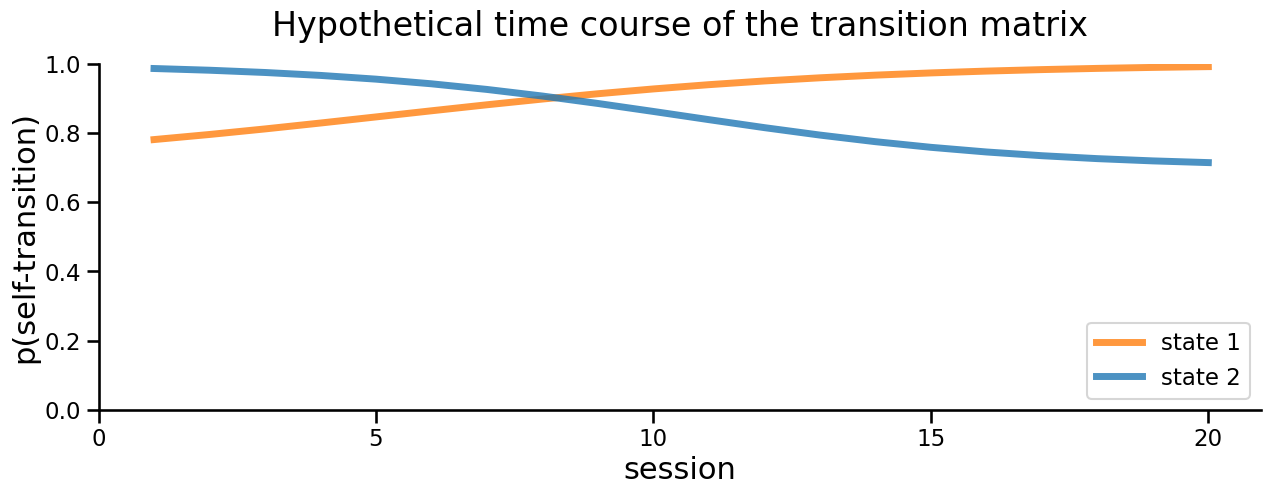

In [4]:
# FIGURE 1B
fig, axes = plt.subplots(1, figsize = (15,4.5))
# x coordinates for plotting
sym = np.linspace(1,-1,S)
nonsym = np.linspace(0.5,-1,S)

trueP1 = generalized_sigmoid(-3,-0.5,0.3,0.7, nonsym) # dynamic transition matrix for state 1
trueP2 = generalized_sigmoid(3,0,0.3,0.7, sym) # dynamic transition matrix for state 2

axes.set_ylim(0,1)
axes.set_ylabel('p(self-transition)', size=22)
axes.set_xlabel('session', size=22)
axes.plot(range(1,S+1),generalized_sigmoid(-3,-0.5,0.3,0.7, nonsym),color=colorsStates[0],linewidth=5,label=f'state 1', alpha=0.8, linestyle='-')
axes.plot(range(1,S+1),generalized_sigmoid(3,0,0.3,0.7, sym),color=colorsStates[1],linewidth=5,label=f'state 2', alpha=0.8, linestyle='-')
axes.legend(loc='lower right')
axes.spines[['right', 'top']].set_visible(False)
axes.set_title('Hypothetical time course of the transition matrix', size=24, pad=20)
axes.set_xticks(np.arange(0,25,5), np.arange(0,25,5))
plt.savefig(f'../figures/Figure1_simulated_transition_matrix.eps', bbox_inches='tight', dpi=300, format='eps')


# Figure 1C

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


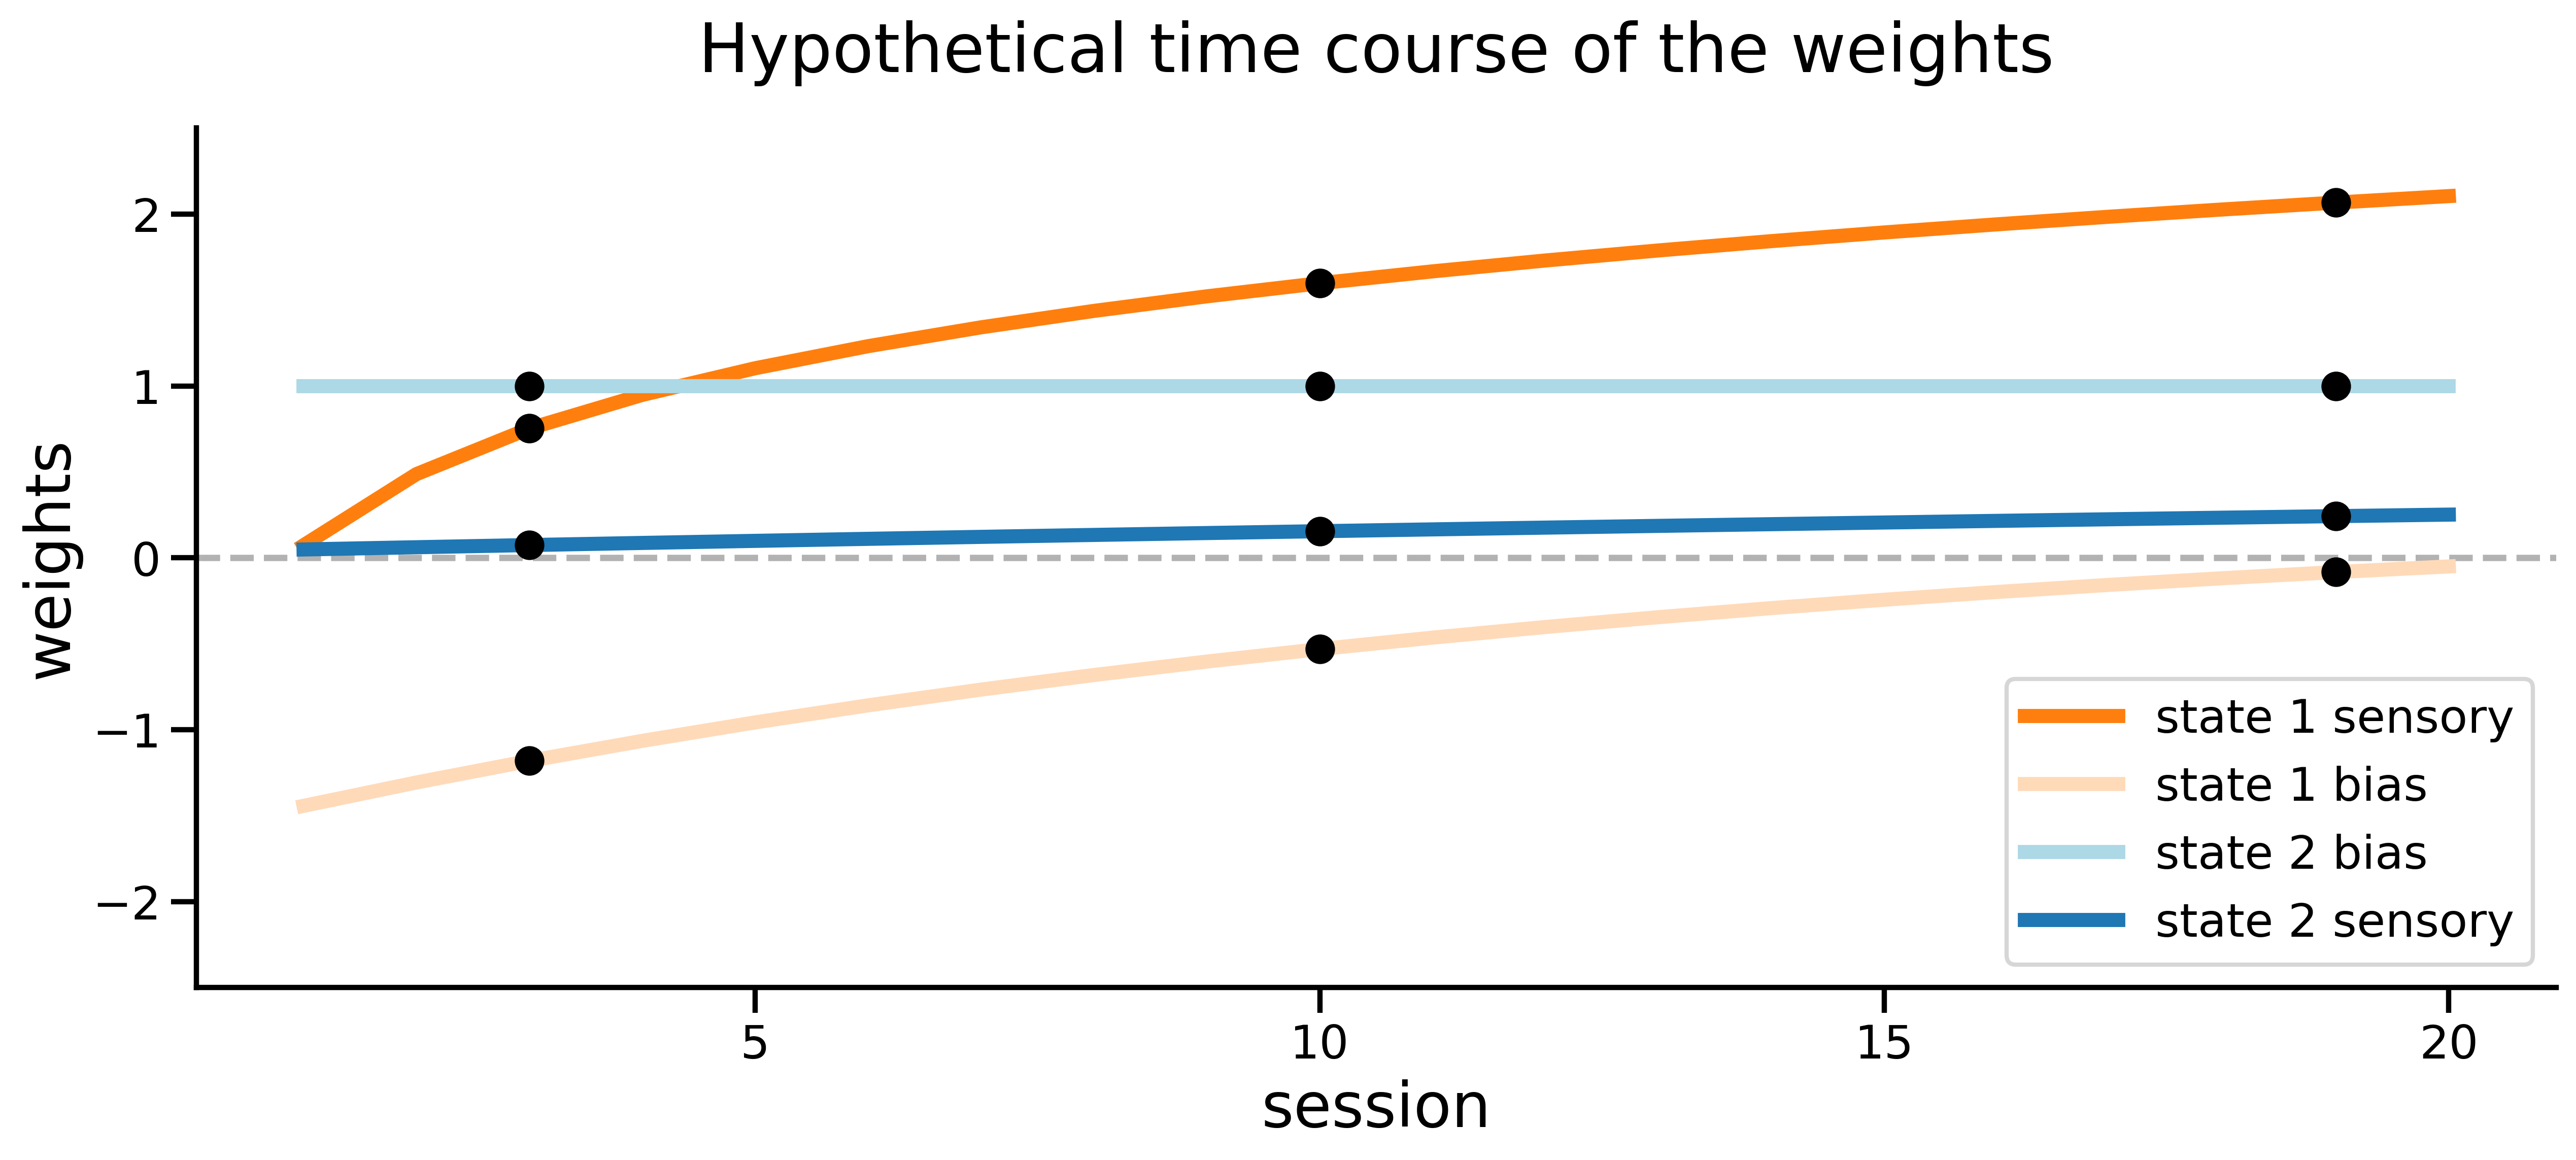

In [5]:
# True Weights and Session Start Indices
ourW = np.zeros((S,K,D))
ourW[:,0,1] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,0] = np.linspace(-1,0,S) # state 1 bias (decreasing)
ourW[:,1,1] = np.linspace(0,0.5,S) # state 2 sensory (flat 0)
ourW[:,1,0] = 1 # state 2 bias (flat 1)

trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
sessInd = []
for sess in range(0,S):
    sessInd.append(sess*T)
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:]
sessInd.append(N)

# transformation of weights to get desired hypothetical parameters
trueW[sessInd[:-1],0,1,1] = generalized_log(0.75, 0.7, 0.1, 1.8, trueW[sessInd[:-1],0,1,1]) # transformation with log
trueW[sessInd[:-1],0,0,1] = generalized_exp(-0.4,-1.5, 0, 0.35, trueW[sessInd[:-1],0,0,1]) # transformation with exp
trueW[sessInd[:-1],1,1,1] = generalized_log(0.5, 0.1, 0.1, 1.2, trueW[sessInd[:-1],1,1,1]) # transformation wtih log

# FIGURE 1C
fig, axes = plt.subplots(1, figsize = (15,5.5), dpi=400)
axes.set_ylim(-2.5,2.5)
axes.set_ylabel('weights', size=22)
axes.set_xlabel('session', size=22)
axes.axhline(0, alpha=0.3, color='black',linestyle='--')
axes.plot(range(1,sess+2), trueW[sessInd[:-1],0,1,1],color=colorsStates[0],linewidth=5,label=f'state 1 sensory', alpha=1, linestyle='-')
axes.plot(range(1,sess+2), trueW[sessInd[:-1],0,0,1], color='peachpuff',linewidth=5,label=f'state 1 bias', alpha=1, linestyle='-')
axes.plot(range(1,sess+2),trueW[sessInd[:-1],1,0,1],color='lightblue',linewidth=5,label=f'state 2 bias', alpha=1, linestyle='-')
axes.plot(range(1,sess+2), trueW[sessInd[:-1],1,1,1],color=colorsStates[1],linewidth=5,label=f'state 2 sensory', alpha=1, linestyle='-')
for earlySess in [3,10,19]: # example sessions
    axes.scatter(earlySess, trueW[sessInd[earlySess-1],0,0,1],color='black',alpha=1,zorder=2)
    axes.scatter(earlySess,trueW[sessInd[earlySess-1],0,1,1],color='black',alpha=1,zorder=2)
    axes.scatter(earlySess,trueW[sessInd[earlySess-1],1,0,1],color='black',alpha=1,zorder=2)
    axes.scatter(earlySess,trueW[sessInd[earlySess-1],1,1,1],color='black',alpha=1,zorder=2)
axes.legend(loc='lower right')
axes.set_title('Hypothetical time course of the weights', size=24, pad=20)
axes.spines[['right', 'top']].set_visible(False)
axes.set_xticks([5,10,15,20],[5,10,15,20])
plt.savefig(f'../figures/Figure1_simulated_weights.eps', bbox_inches='tight', dpi=300, format='eps')

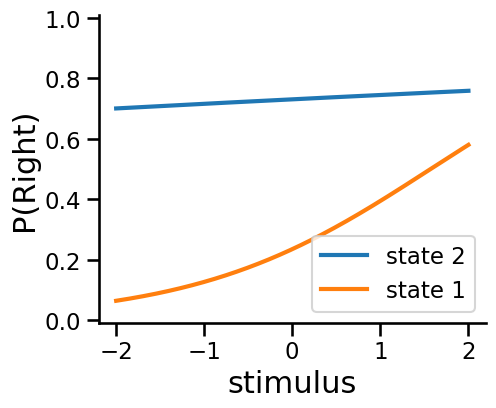

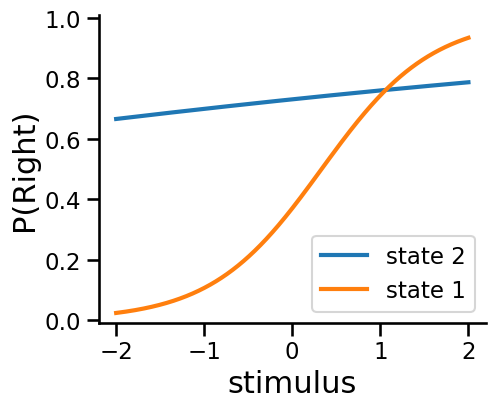

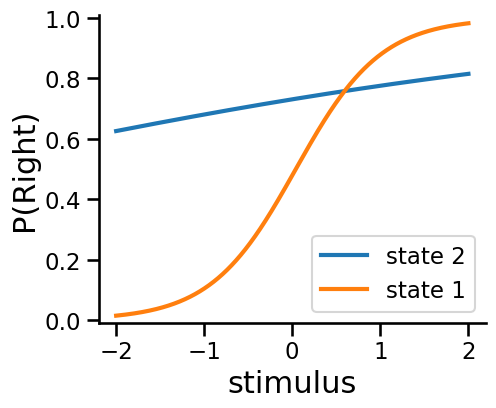

In [6]:
# plotting psychometrics for example sessions
for session in [3,10,19]:
    fig, axes = plt.subplots(figsize=(5,4))
    plotting_psychometric(w=trueW, sessInd=sessInd, session=session-1, axes=axes, colorsStates=colorsStates, size=24, linewidth=3)
    axes.spines[['right', 'top']].set_visible(False)
    axes.set_title('')
